# Cavern storage capacity

In [1]:
import os

import cartopy.crs as ccrs
import contextily as cx
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar

from src import capacity as cap
from src import data as rd
from src import functions as fns

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

## Halite data

In [3]:
ds, extent = rd.kish_basin_data_depth_adjusted(
    dat_path=os.path.join("data", "kish-basin"),
    bathymetry_path=os.path.join("data", "bathymetry"),
)

In [4]:
xmin, ymin, xmax, ymax = extent.total_bounds

## Constraints

### Exploration wells

In [5]:
# 500 m buffer - suggested in draft OREDP II p. 108
wells, wells_b = fns.constraint_exploration_well(
    data_path=os.path.join(
        "data",
        "exploration-wells",
        "Exploration_Wells_Irish_Offshore.shapezip.zip",
    )
)

### Wind farms

In [6]:
# the shapes are used as is without a buffer - suggested for renewable energy
# test site areas in draft OREDP II p. 109
wind_farms = fns.constraint_wind_farm(
    data_path=os.path.join(
        "data", "wind-farms", "wind-farms-foreshore-process.zip"
    ),
    dat_extent=extent,
)

### Frequent shipping routes

In [7]:
# 1 NM (1,852 m) buffer - suggested in draft OREDP II p. 108
shipping, shipping_b = fns.constraint_shipping_routes(
    data_path=os.path.join(
        "data", "shipping", "shipping_frequently_used_routes.zip"
    ),
    dat_extent=extent,
)

### Shipwrecks

In [8]:
# Archaeological Exclusion Zones recommendation - 100 m buffer
shipwrecks, shipwrecks_b = fns.constraint_shipwrecks(
    data_path=os.path.join(
        "data", "shipwrecks", "IE_GSI_MI_Shipwrecks_IE_Waters_WGS84_LAT.zip"
    ),
    dat_extent=extent,
)

### Subsea cables

In [9]:
# 750 m buffer - suggested in draft OREDP II p. 109-111
cables, cables_b = fns.constraint_subsea_cables(
    data_path=os.path.join("data", "subsea-cables", "KIS-ORCA.gpkg")
)

### Distance from salt formation edge

In [10]:
edge_buffer = fns.constraint_halite_edge(dat_xr=ds)

## Zones of interest

In [11]:
# height = 85 m, 500 m <= depth <= 2,000 m, diameter = 80 m,
# separation = 320 m
zones, zds = fns.zones_of_interest(
    dat_xr=ds, constraints={"height": 85, "min_depth": 500, "max_depth": 2000}
)

## Generate caverns

In [12]:
caverns, caverns_excl = fns.generate_caverns_with_constraints(
    zones_gdf=zones,
    zones_ds=zds,
    dat_extent=extent,
    exclusions={
        "wells": wells_b,
        "wind_farms": wind_farms,
        "shipwrecks": shipwrecks_b,
        "shipping": shipping_b,
        "cables": cables_b,
        "edge": edge_buffer,
    },
)

Without constraints...
Number of potential caverns: 4,168
------------------------------------------------------------
Exclude salt formation edges...
Number of potential caverns: 4,082
Caverns excluded: 2.06%
------------------------------------------------------------
Exclude frequent shipping routes...
Number of potential caverns: 1,775
Caverns excluded: 57.41%
------------------------------------------------------------
Exclude subsea cables...
Number of potential caverns: 1,707
Caverns excluded: 59.05%
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 1,347
Caverns excluded: 67.68%
------------------------------------------------------------
Exclude exploration wells...
Number of potential caverns: 1,347
Caverns excluded: 67.68%
------------------------------------------------------------
Exclude shipwrecks...
Number of potential caverns: 1,347
Caverns excluded: 67.68%
---------------------------------------------------

In [13]:
# label caverns by height and depth
caverns = fns.label_caverns(
    cavern_df=caverns,
    heights=[85, 155, 311],
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

## Capacity

### Volume

In [14]:
caverns["cavern_volume"] = cap.cavern_volume(height=caverns["cavern_height"])
caverns["cavern_volume"] = cap.corrected_cavern_volume(
    v_cavern=caverns["cavern_volume"]
)

### Mid-point temperature

In [15]:
caverns["t_mid_point"] = cap.temperature_cavern_mid_point(
    height=caverns["cavern_height"], depth_top=caverns["cavern_depth"]
)

### Operating pressure

In [16]:
(
    caverns["p_operating_min"],
    caverns["p_operating_max"],
) = cap.pressure_operating(thickness_overburden=caverns["TopDepthSeabed"])

### Hydrogen gas density

In [17]:
caverns["rho_min"], caverns["rho_max"] = cap.density_hydrogen_gas(
    p_operating_min=caverns["p_operating_min"],
    p_operating_max=caverns["p_operating_max"],
    t_mid_point=caverns["t_mid_point"],
)

### Working mass of hydrogen

In [18]:
caverns["working_mass"] = cap.mass_hydrogen_working(
    rho_h2_min=caverns["rho_min"],
    rho_h2_max=caverns["rho_max"],
    v_cavern=caverns["cavern_volume"],
)

### Energy storage capacity in GWh

In [19]:
caverns["capacity"] = cap.energy_storage_capacity(
    m_working=caverns["working_mass"]
)

## Stats

In [20]:
caverns.drop(
    ["x", "y", "TopTWT", "BaseDepth", "TopDepth", "BaseDepthSeabed"], axis=1
).describe()

,Thickness,TopDepthSeabed,cavern_height,cavern_depth,cavern_volume,t_mid_point,p_operating_min,p_operating_max,rho_min,rho_max,working_mass,capacity
count,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000,1.347000e+03,1.347000e+03,1347.000000,1347.000000,1.347000e+03,1347.000000
mean,301.479921,1024.240817,152.052710,1104.240817,319356.851458,327.410019,7.558148e+06,2.015506e+07,5.266550,13.057687,2.525138e+06,84.143220
std,82.291249,406.260799,64.239749,406.260799,154668.689090,15.415568,2.869501e+06,7.652003e+06,1.677860,3.880812,1.534296e+06,51.126149
min,175.062400,420.852325,85.000000,500.852325,157915.456354,303.552153,3.296294e+06,8.790118e+06,2.572326,6.646515,6.468781e+05,21.555415
25%,236.595850,694.302203,85.000000,774.302203,157915.456354,314.537763,5.227725e+06,1.394060e+07,3.909884,9.931411,1.456825e+06,48.544650
50%,289.801400,944.222332,155.000000,1024.222332,326452.980096,324.500569,6.992961e+06,1.864790e+07,5.026431,12.583327,2.148724e+06,71.600267
75%,353.118400,1327.124190,155.000000,1407.124190,326452.980096,338.835331,9.697474e+06,2.585993e+07,6.580477,16.147320,3.108529e+06,103.583108
max,754.985800,1919.333583,311.000000,1999.333583,702050.890150,361.569900,1.388037e+07,3.701431e+07,8.690480,20.761646,8.254337e+06,275.052853


In [21]:
# cavern volumes
list(caverns["cavern_volume"].unique())

[702050.8901495441, 326452.98009604175, 157915.45635408553]

In [22]:
# total capacity
caverns[["capacity"]].sum().iloc[0]

113340.91766105605

In [23]:
# total capacity at various depth/height combinations
s = caverns.groupby(["height", "depth"], sort=False)[["capacity"]].sum()
s["%"] = s["capacity"] / caverns[["capacity"]].sum().iloc[0] * 100
s

capacity          %
height depth                                 
311    1,000 - 1,500  14447.238902  12.746711
       500 - 1,000     5909.116413   5.213577
       1,500 - 2,000   9315.548488   8.219052
155    1,000 - 1,500  27053.548505  23.869181
       1,500 - 2,000  17059.676796  15.051649
       500 - 1,000    23912.086662  21.097488
85     1,000 - 1,500   3831.024405   3.380089
       1,500 - 2,000   4864.316266   4.291757
       500 - 1,000     6948.361223   6.130497

In [24]:
s.groupby("depth").sum()[["capacity"]]

,capacity
depth,
"1,000 - 1,500",45331.811812
"1,500 - 2,000",31239.541550
"500 - 1,000",36769.564299


In [25]:
s.groupby("height").sum()[["capacity"]]

,capacity
height,
155,68025.311963
311,29671.903803
85,15643.701895


In [26]:
# number of caverns
s = caverns.groupby(["height", "depth"], sort=False)[["capacity"]].count()
s["%"] = s["capacity"] / len(caverns) * 100
s

capacity          %
height depth                             
311    1,000 - 1,500        71   5.270973
       500 - 1,000          42   3.118040
       1,500 - 2,000        37   2.746845
155    1,000 - 1,500       286  21.232368
       1,500 - 2,000       140  10.393467
       500 - 1,000         380  28.210839
85     1,000 - 1,500        84   6.236080
       1,500 - 2,000        84   6.236080
       500 - 1,000         223  16.555308

In [27]:
s.groupby("depth").sum()[["capacity"]]

,capacity
depth,
"1,000 - 1,500",441
"1,500 - 2,000",261
"500 - 1,000",645


In [28]:
s.groupby("height").sum()[["capacity"]]

,capacity
height,
155,806
311,150
85,391


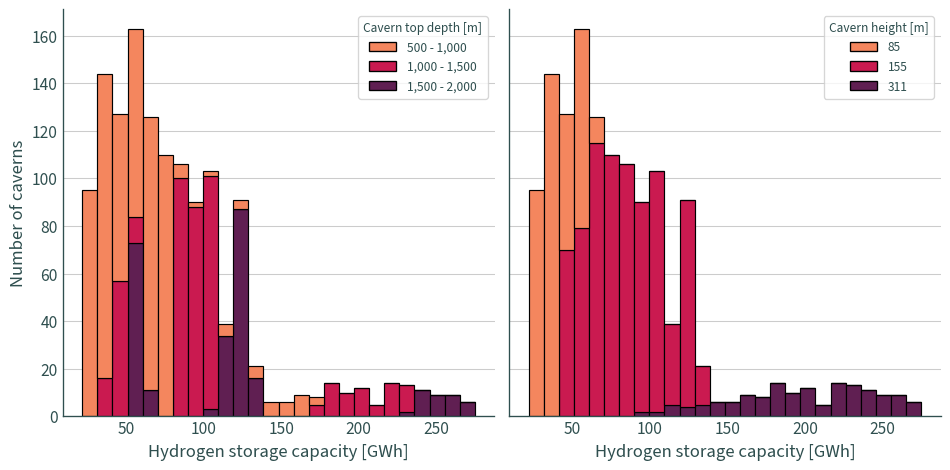

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.histplot(
    caverns.rename(columns={"depth": "Cavern top depth [m]"}).sort_values(
        "TopDepthSeabed"
    ),
    x="capacity",
    hue="Cavern top depth [m]",
    palette="rocket_r",
    multiple="stack",
    alpha=1,
    ax=axes[0],
)
sns.histplot(
    caverns.rename(columns={"height": "Cavern height [m]"}).sort_values(
        "Thickness"
    ),
    x="capacity",
    hue="Cavern height [m]",
    palette="rocket_r",
    multiple="stack",
    alpha=1,
    ax=axes[1],
)
axes[0].set_xlabel("Hydrogen storage capacity [GWh]")
axes[1].set_xlabel("Hydrogen storage capacity [GWh]")
axes[0].grid(which="major", axis="y")
axes[1].grid(which="major", axis="y")
axes[0].set_ylabel("Number of caverns")
sns.despine()
plt.tight_layout()
plt.show()

## Maps

In [30]:
# create exclusion buffer
buffer = pd.concat([wells_b, shipwrecks_b, shipping_b, cables_b]).dissolve()

In [31]:
def plot_map_alt(dat_xr, cavern_df, zones_gdf, classes, colours, labels):
    """
    Helper function to plot caverns within the zones of interest
    """

    plt.figure(figsize=(20, 11.5))
    axis = plt.axes(projection=ccrs.epsg(rd.CRS))
    legend_handles = []

    # halite boundary - use buffering to smooth the outline
    shape = rd.halite_shape(dat_xr=dat_xr).buffer(1000).buffer(-1000)
    shape.plot(
        ax=axis,
        edgecolor="darkslategrey",
        color="none",
        linewidth=2,
        alpha=0.5,
        zorder=2,
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            linewidth=2,
            edgecolor="darkslategrey",
            label="Kish Basin boundary",
            alpha=0.5,
        )
    )

    zones_gdf.plot(
        ax=axis, zorder=1, linewidth=0, facecolor="white", alpha=0.45
    )
    zones_gdf.plot(
        ax=axis,
        zorder=2,
        edgecolor="slategrey",
        linestyle="dotted",
        linewidth=1.25,
        facecolor="none",
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            linestyle="dotted",
            edgecolor="slategrey",
            label="Feasible area",
            linewidth=1.25,
        )
    )

    pd.concat([buffer, wind_farms]).dissolve().clip(shape).plot(
        ax=axis,
        facecolor="none",
        linewidth=0.65,
        edgecolor="slategrey",
        zorder=2,
        alpha=0.5,
        hatch="//",
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            hatch="//",
            edgecolor="slategrey",
            label="Exclusion area",
            alpha=0.65,
            linewidth=0.5,
        )
    )

    legend_handles.append(
        mpatches.Patch(
            label="Hydrogen storage \ncapacity [GWh]", visible=False
        )
    )

    for x, y, z in zip(classes, colours, labels):
        if x == 0:
            c = cavern_df[cavern_df["capacity"] < x + 40]
        elif x == 160:
            c = cavern_df[cavern_df["capacity"] >= x]
        else:
            c = cavern_df[
                (cavern_df["capacity"] >= x) & (cavern_df["capacity"] < x + 40)
            ]
        for df, markersize in zip(
            [
                c[c["depth"] == "500 - 1,000"],
                c[c["depth"] == "1,000 - 1,500"],
                c[c["depth"] == "1,500 - 2,000"],
            ],
            [20, 50, 20],
        ):
            if len(df) > 0:
                df.centroid.plot(
                    ax=axis,
                    zorder=3,
                    linewidth=0,
                    marker=".",
                    markersize=markersize,
                    color=sns.color_palette("flare", 256)[y],
                )
        legend_handles.append(
            mpatches.Patch(
                facecolor=sns.color_palette("flare", 256)[y], label=z
            )
        )

    legend_handles.append(
        mpatches.Patch(label="Cavern top depth [m]", visible=False)
    )
    for markersize, label in zip(
        [6, 3], ["1,000 - 1,500", "500 - 1,000 or \n1,500 - 2,000"]
    ):
        legend_handles.append(
            Line2D(
                [0],
                [0],
                marker=".",
                linewidth=0,
                label=label,
                color="darkslategrey",
                markersize=markersize,
            )
        )

    plt.xlim(shape.bounds["minx"][0] - 1000, shape.bounds["maxx"][0] + 1000)
    plt.ylim(shape.bounds["miny"][0] - 1000, shape.bounds["maxy"][0] + 1000)

    cx.add_basemap(
        axis, crs=rd.CRS, source=cx.providers.CartoDB.VoyagerNoLabels
    )
    axis.gridlines(
        draw_labels={"bottom": "x", "left": "y"},
        alpha=0.25,
        color="darkslategrey",
    )
    axis.add_artist(
        ScaleBar(1, box_alpha=0, location="lower right", color="darkslategrey")
    )
    plt.legend(
        loc="lower right",
        bbox_to_anchor=(1, 0.05),
        handles=legend_handles,
        fontsize=11.5,
    )

    plt.tight_layout()
    plt.show()

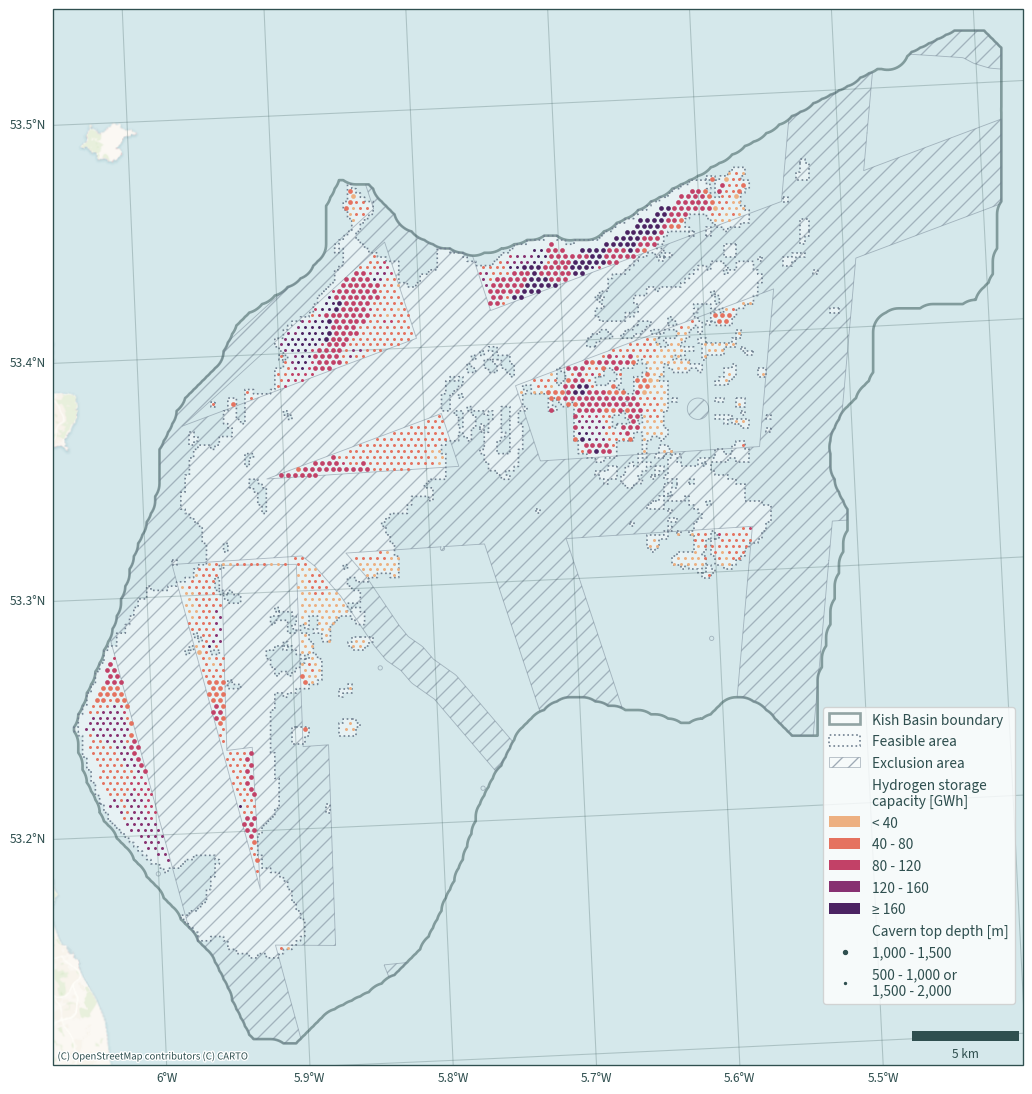

In [32]:
plot_map_alt(
    ds,
    caverns,
    zones,
    [40 * n for n in range(5)],
    [0] + [int(256 / 4) + int(256 / 4) * n - 1 for n in range(4)],
    ["< 40", "40 - 80", "80 - 120", "120 - 160", "≥ 160"],
)

## Restrict cavern height to 155 m

In [33]:
# height = 85 m, 500 m <= depth <= 2,000 m, diameter = 80 m,
# separation = 320 m
zones, zds = fns.zones_of_interest(
    dat_xr=ds, constraints={"height": 155, "min_depth": 500, "max_depth": 2000}
)

In [34]:
caverns, caverns_excl = fns.generate_caverns_with_constraints(
    zones_gdf=zones,
    zones_ds=zds,
    dat_extent=extent,
    exclusions={
        "wells": wells_b,
        "wind_farms": wind_farms,
        "shipwrecks": shipwrecks_b,
        "shipping": shipping_b,
        "cables": cables_b,
        "edge": edge_buffer,
    },
)

Without constraints...
Number of potential caverns: 2,471
------------------------------------------------------------
Exclude salt formation edges...
Number of potential caverns: 2,412
Caverns excluded: 2.39%
------------------------------------------------------------
Exclude frequent shipping routes...
Number of potential caverns: 1,018
Caverns excluded: 58.80%
------------------------------------------------------------
Exclude subsea cables...
Number of potential caverns: 1,002
Caverns excluded: 59.45%
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 851
Caverns excluded: 65.56%
------------------------------------------------------------
Exclude exploration wells...
Number of potential caverns: 851
Caverns excluded: 65.56%
------------------------------------------------------------
Exclude shipwrecks...
Number of potential caverns: 851
Caverns excluded: 65.56%
---------------------------------------------------------

In [35]:
# label caverns by height and depth
caverns = fns.label_caverns(
    cavern_df=caverns,
    heights=[155],
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

In [36]:
caverns["cavern_volume"] = cap.cavern_volume(height=caverns["cavern_height"])
caverns["cavern_volume"] = cap.corrected_cavern_volume(
    v_cavern=caverns["cavern_volume"]
)

caverns["t_mid_point"] = cap.temperature_cavern_mid_point(
    height=caverns["cavern_height"], depth_top=caverns["cavern_depth"]
)

(
    caverns["p_operating_min"],
    caverns["p_operating_max"],
) = cap.pressure_operating(thickness_overburden=caverns["TopDepthSeabed"])

caverns["rho_min"], caverns["rho_max"] = cap.density_hydrogen_gas(
    p_operating_min=caverns["p_operating_min"],
    p_operating_max=caverns["p_operating_max"],
    t_mid_point=caverns["t_mid_point"],
)

caverns["working_mass"] = cap.mass_hydrogen_working(
    rho_h2_min=caverns["rho_min"],
    rho_h2_max=caverns["rho_max"],
    v_cavern=caverns["cavern_volume"],
)

caverns["capacity"] = cap.energy_storage_capacity(
    m_working=caverns["working_mass"]
)

In [37]:
caverns.drop(
    ["x", "y", "TopTWT", "BaseDepth", "TopDepth", "BaseDepthSeabed"], axis=1
).describe()

,Thickness,TopDepthSeabed,height,cavern_height,cavern_depth,cavern_volume,t_mid_point,p_operating_min,p_operating_max,rho_min,rho_max,working_mass,capacity
count,851.000000,851.000000,851.0,851.0,851.000000,851.000000,851.000000,8.510000e+02,8.510000e+02,851.000000,851.000000,8.510000e+02,851.000000
mean,344.543169,1047.072619,155.0,155.0,1127.072619,326452.980096,328.321473,7.719413e+06,2.058510e+07,5.365741,13.290885,2.587187e+06,86.210812
std,70.285900,400.034643,0.0,0.0,400.034643,0.000000,15.001299,2.825525e+06,7.534733e+06,1.651744,3.819149,7.077757e+05,23.584659
min,245.000700,420.852325,155.0,155.0,500.852325,326452.980096,304.838212,3.296294e+06,8.790118e+06,2.572326,6.646515,1.330031e+06,44.319586
25%,290.926800,711.809265,155.0,155.0,791.809265,326452.980096,315.749097,5.351381e+06,1.427035e+07,3.987215,10.117476,2.001242e+06,66.685823
50%,336.350300,1000.921836,155.0,155.0,1080.921836,326452.980096,326.590819,7.393441e+06,1.971584e+07,5.270445,13.153263,2.573370e+06,85.750393
75%,380.405100,1333.897833,155.0,155.0,1413.897833,326452.980096,339.077419,9.745317e+06,2.598751e+07,6.615730,16.226093,3.137332e+06,104.542866
max,754.985800,1919.333583,155.0,155.0,1999.333583,326452.980096,361.031259,1.388037e+07,3.701431e+07,8.690480,20.761646,3.940668e+06,131.311822


In [38]:
# cavern volumes
list(caverns["cavern_volume"].unique())

[326452.98009604175]

In [39]:
# total capacity
caverns[["capacity"]].sum().iloc[0]

73365.4008702874

In [40]:
# total capacity at various depth/height combinations
s = caverns.groupby(["height", "depth"], sort=False)[["capacity"]].sum()
s["%"] = s["capacity"] / caverns[["capacity"]].sum().iloc[0] * 100
s

capacity          %
height depth                                 
155    1,000 - 1,500  30738.928537  41.898399
       500 - 1,000    23061.578890  31.433862
       1,500 - 2,000  19564.893444  26.667739

In [41]:
# total volume at various depth/height combinations
s = caverns.groupby(["height", "depth"], sort=False)[["cavern_volume"]].sum()
s["%"] = s["cavern_volume"] / caverns[["cavern_volume"]].sum().iloc[0] * 100
s

cavern_volume          %
height depth                                  
155    1,000 - 1,500   1.060972e+08  38.190364
       500 - 1,000     1.188289e+08  42.773208
       1,500 - 2,000   5.288538e+07  19.036428

In [42]:
# number of caverns
s = caverns.groupby(["height", "depth"], sort=False)[["cavern_volume"]].count()
s["%"] = s["cavern_volume"] / len(caverns) * 100
s

cavern_volume          %
height depth                                  
155    1,000 - 1,500            325  38.190364
       500 - 1,000              364  42.773208
       1,500 - 2,000            162  19.036428

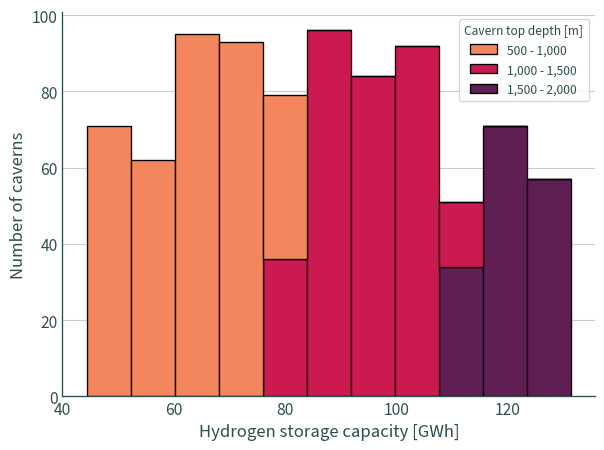

In [43]:
ax = sns.histplot(
    caverns.rename(columns={"depth": "Cavern top depth [m]"}).sort_values(
        "TopDepthSeabed"
    ),
    x="capacity",
    hue="Cavern top depth [m]",
    palette="rocket_r",
    multiple="stack",
    alpha=1,
)
ax.set_xlabel("Hydrogen storage capacity [GWh]")
ax.grid(which="major", axis="y")
ax.set_ylabel("Number of caverns")
sns.despine()
plt.tight_layout()
plt.show()

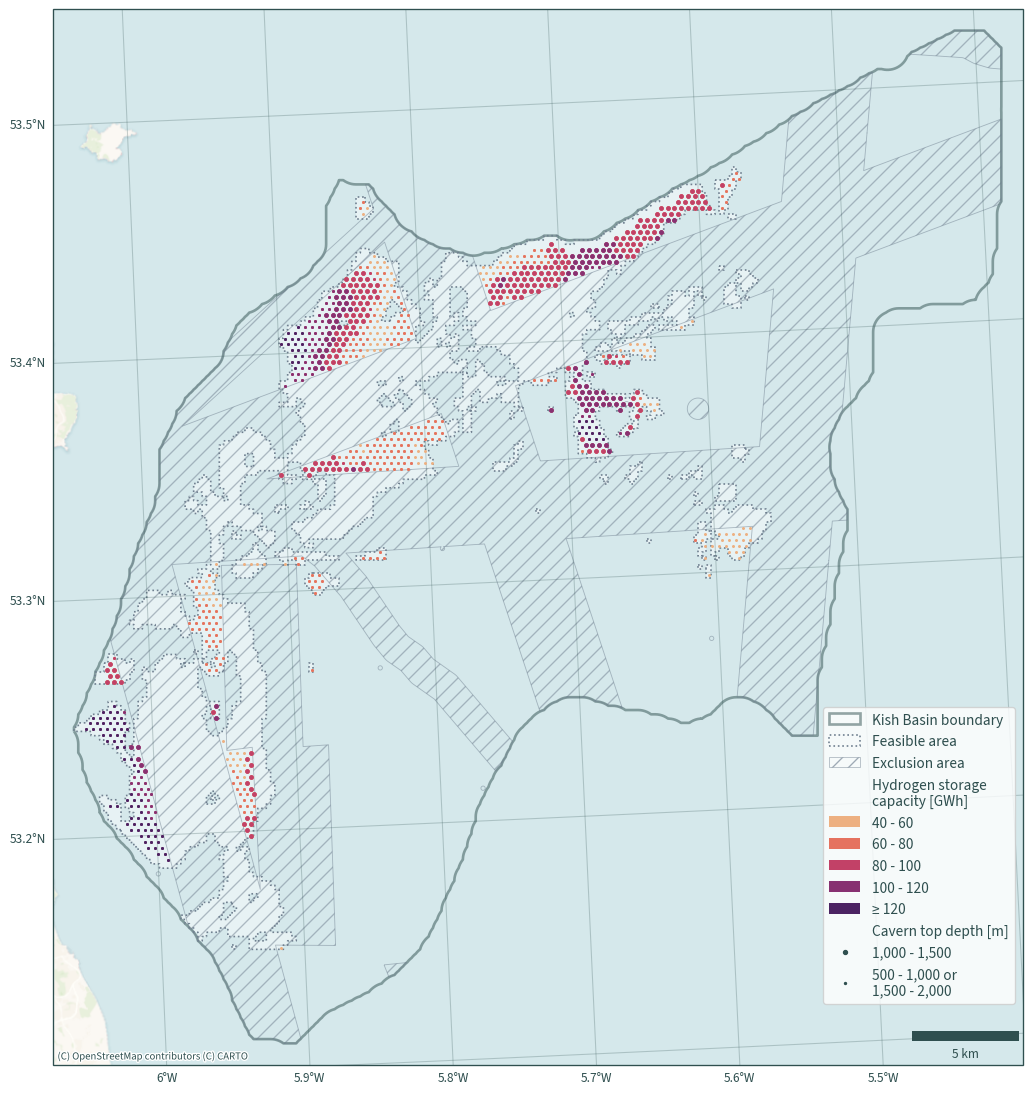

In [44]:
plot_map_alt(
    ds,
    caverns,
    zones,
    [20 + 20 * n for n in range(1, 6)],
    [0] + [int(256 / 4) + int(256 / 4) * n - 1 for n in range(4)],
    ["40 - 60", "60 - 80", "80 - 100", "100 - 120", "≥ 120"],
)